# Load libraries and Data

In [51]:
from pyhive import presto

def get_presto_conn():
    # need to impersonate to the owner to drop exisiting tables
    return presto.connect(host='presto-alpha-backend.data.houzz.net', port=8086, username='shahidhya')

def presto_query(query, presto_conn, fetchall=True):
    cursor = presto_conn.cursor()
    cursor.execute(query)
    header = list(map(operator.itemgetter(0), cursor.description))
    return header, cursor.fetchall()
conn = get_presto_conn() 

import pandas as pd
import numpy as np
from IPython.display import display, HTML
import matplotlib.pyplot as plt

pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_rows', 10)
pd.set_option('display.max_columns', 500)

from scipy import stats, integrate
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(color_codes=True)

# MP Checkout mweb v3

In [2]:
# latest ramp period
start_date = '2022-05-03'
end_date = '2022-05-25'
test_name = 'mp_checkout_mweb_v3'
control = 'control'
treatment = 'treatment'
# device_cat = "('Personal computer')" 
device_cat = "('Tablet','Smartphone')"
tmp_visitor_base = 'wandajuan.visitor_base_' + test_name
tmp_mp_metrics = 'wandajuan.mp_metrics_' + test_name
tmp_xo_metrics = 'wandajuan.xo_metrics_' + test_name
tmp_xo_funnels = 'wandajuan.xo_funnel_action_' + test_name
tmp_final_table = 'wandajuan.' + test_name

## User Base

In [3]:
# Test user base:

q = """DROP TABLE IF EXISTS {tmp_visitor_base}""".format(tmp_visitor_base=tmp_visitor_base)
pd.read_sql(q, conn)

print('run query below in presto:')


q = """
CREATE TABLE {tmp_visitor_base} AS
with first_trigger as
    (
    SELECT 
       visitor_id
       , min(test_variant) as test_value_min
       , max(test_variant) as test_value_max
       , min(dt) as ft_dt
    FROM l2.test_selection
    WHERE test_name = '{test_name}'
    and dt BETWEEN '{start_date}' AND '{end_date}'
    and visitor_id in (
                        select distinct visitor_id
                            from l2.session_analytics core 
                        WHERE core.dt BETWEEN '{start_date}' AND '{end_date}'
                          and CAST(country as varchar) in ('US') 
                          and CAST(site_id as varchar) in ('101') 
                          AND device_cat != '' 
                          AND (test_set like '%{test_name}=%') 
                          and device_cat in {device_cat}
                          and session_id not in (
                                            select session_id 
                                            from l2.session_summary 
                                            where user_agent like '%test_automation%' 
                                            and dt>= '{start_date}') 
                      )
    group by visitor_id
    having min(test_variant) = max(test_variant)
    )
    SELECT visitor_id,test_value_min as test_variant, ft_dt as dt
    FROM first_trigger
""".format(tmp_visitor_base=tmp_visitor_base,
            test_name=test_name,
            start_date=start_date,
            end_date=end_date,
              device_cat = device_cat)

# print(q)
pd.read_sql(q, conn)

run query below in presto:


,rows
0,5289


In [4]:
pd.read_sql("""Select test_variant,  count(visitor_id) from {tmp_visitor_base} group by 1 order by 1""".format(tmp_visitor_base=tmp_visitor_base),conn)

,test_variant,_col1
0,control,2660
1,control_qa,1
2,treatment,2628


In [5]:
test_users = pd.read_sql('select * from {tmp_visitor_base}'.format(tmp_visitor_base=tmp_visitor_base), conn)
test_users

,visitor_id,test_variant,dt
0,faaa1ba2-5cda-44f4-9071-083baaaa6568,treatment,2022-05-23
1,9a108a50-f2cc-4931-a00e-88c258d93954,treatment,2022-05-12
2,01e784c5-653d-4c1d-a3a6-9c897944782c,control,2022-05-20
3,23ff6616-9264-47e0-ac78-1f8afcc01673,control,2022-05-13
4,9eeaeebb-1833-4b25-8af1-de1ccd52e09f,treatment,2022-05-03
...,...,...,...
5284,35df7880-0de3-4727-92ad-5148c35f92f3,control,2022-05-10
5285,3eaf80a5-89ea-4840-924d-cc3c871747e6,treatment,2022-05-15
5286,cc543790-c80b-4c29-9fac-7f622add160b,control,2022-05-11
5287,ec4fccba-2601-4e33-ad6e-88812bc75bd7,control,2022-05-07


## MP table

In [6]:
# MP Metrics: since there are not that many rows - 2K+ -> pull the entire pos
pd.read_sql('drop table if exists {tmp_mp_metrics}'.format(tmp_mp_metrics=tmp_mp_metrics), conn)


print('run query below in presto:')

q = """
CREATE TABLE {tmp_mp_metrics} AS

select 
		t0.*,
		t2.order_date, 
		t2.order_id,
		t2.created,
		t2.status,
		t2.item_id, 
		t2.house_id,
		t2.item_gmv,
		t2.init_item_commission,
		t2.gmv_net_of_returns,
		t2.net_commission,
		t2.placed_order_item_coupon_amount,
		t2.is_trade_program,
		t2.session_id,
		t2.medium,
		t2.l1_category,
		t2.browser,
		t2.os,
		t2.device_cat,
		t2.channel,
		t2.new_visitor,
		t2.landing_page_class,
		
		( case when checkout_type = 'FIRST_UNCANCELLED_CHECKOUT' then t2.order_id end) as new_orders,
		( case when checkout_type != 'FIRST_UNCANCELLED_CHECKOUT' then t2.order_id end) as old_orders,
		( case when billing_info like '%paymentMethodType":0%' then t2.order_id end) as cc_orders,
		( case when billing_info like '%paymentMethodType":1%' then t2.order_id end) as apple_pay_orders,
		( case when billing_info like '%paymentMethodType":4%' then t2.order_id end) as afterpay_orders,
		( case when billing_info like '%paymentMethodType":3%' then t2.order_id end) as paypal_orders,
		( case when billing_info like '%paymentMethodType":0%' then t2.item_gmv end) as cc_gmv,
		( case when billing_info like '%paymentMethodType":1%' then t2.item_gmv end) as apple_pay_gmv,
		( case when billing_info like '%paymentMethodType":4%' then t2.item_gmv end) as afterpay_gmv,
		( case when billing_info like '%paymentMethodType":3%' then t2.item_gmv end) as paypal_gmv
from {tmp_visitor_base} t0 
join  mp_test.order_item_details t2 
  on t0.visitor_id = t2.visitor_id 
  and t2.order_date >= t0.dt 
  and order_date between '{start_date}' and '{end_date}' 
join logs.marketplace_valid_orders_detailed_daily t4
    on t2.order_id = t4.order_id
where t2.status in (0,1,2,3,4,5,20,99) 
  and t2.is_impersonated = 0
  -- not excluding trade orders 
--  and is_trade_program = 0
-- GROUP BY 1 ,2
""".format(tmp_visitor_base=tmp_visitor_base,
           tmp_mp_metrics = tmp_mp_metrics,
           start_date=start_date,
           end_date=end_date)

# print(q)
pd.read_sql(q, conn)

run query below in presto:


,rows
0,4600


In [71]:
# mp = pd.read_sql("select * from {tmp_mp_metrics}".format(tmp_mp_metrics=tmp_mp_metrics), conn)
# mp

## XO Table

In [7]:
# Checkout Metrics:

pd.read_sql('drop table if exists {tmp_xo_metrics}'.format(tmp_xo_metrics=tmp_xo_metrics), conn)


print('run query below in presto:')

q = """
CREATE TABLE {tmp_xo_metrics} AS

select 
	t0.test_variant,
	t0.dt as trigger_dt,
	t2.*
from {tmp_visitor_base} t0 
join l2.session_analytics t2 
  on t0.visitor_id = t2.visitor_id 
  and t2.dt >= t0.dt 
where t2.dt between '{start_date}' and '{end_date}' 
-- GROUP BY 1 ,2
""".format(tmp_visitor_base=tmp_visitor_base,
           tmp_xo_metrics = tmp_xo_metrics,
           start_date=start_date,
           end_date=end_date)

# print(q)
pd.read_sql(q, conn)

run query below in presto:


,rows
0,19540


In [9]:
# xo = pd.read_sql("select * from {tmp_xo_metrics}".format(tmp_xo_metrics = tmp_xo_metrics), conn)
# xo

## XO funnel actions

In [57]:

# Checkout funnel with sign in status at the time of performing checkout actions:
pd.read_sql('drop table if exists {tmp_xo_funnels}'.format(tmp_xo_funnels=tmp_xo_funnels), conn)

print('run query below in presto:')

q = """
CREATE TABLE {tmp_xo_funnels} AS

select 
	t0.test_variant,
	t0.dt as trigger_dt,
	t2.*,
	coalesce(json_extract_scalar(action_metadata, '$.app'), json_extract_scalar(action_metadata, '$.originatingPageData["app"]'))  app,
	coalesce(json_extract_scalar(action_metadata, '$.isUserSignedIn'), json_extract_scalar(action_metadata, '$.originatingPageData["isUserSignedIn"]'))  isUserSignedIn	
from {tmp_visitor_base} t0
join l2.user_action_daily t2
on t0.visitor_id = t2.visitor_id 
  and t2.dt >= t0.dt 
where t2.dt between '{start_date}' and '{end_date}' 
and (t2.action like '%CHECKOUT%' 
--or t2.action like '%CART%'
or t2.action like '%SIGN%'
)
-- GROUP BY 1 ,2
""".format(tmp_visitor_base=tmp_visitor_base,
           tmp_xo_funnels = tmp_xo_funnels,
           start_date=start_date,
           end_date=end_date)

# print(q)
pd.read_sql(q, conn)

run query below in presto:


,rows
0,32335


In [11]:
# xo_action = pd.read_sql("select * from {tmp_xo_funnels}".format(tmp_xo_funnels=tmp_xo_funnels), conn)
# xo_action

## Final Table

In [9]:
# Final Table:
pd.read_sql('drop table if exists {tmp_final_table}'.format(tmp_final_table=tmp_final_table), conn)

print('run query below in presto:')

q = """
CREATE TABLE {tmp_final_table} AS

with xo as (

select dt, test_variant, visitor_id, 

	-- xo metrics
		sum(coalesce(browse_products, 0)) browse_products,
		sum(coalesce(view_product, 0)) view_product,
 	    sum(coalesce(sm.cart_add,0)) as cart_add,
        sum(coalesce(sm.view_cart,0)) as view_cart,
	    sum(coalesce(sm.checkout_launch,0)) as checkout_launch,
    	sum(coalesce(sm.checkout_shipping,0)) as checkout_shipping,
    	sum(coalesce(sm.checkout_billing_and_payment,0)) as checkout_billing_and_payment,
    	sum(coalesce(sm.checkout_order_review,0)) as checkout_order_review,
	    sum(coalesce(sm.checkout_order_confirmation,0)) as checkout_order_confirmation,
	    sum(coalesce(sm.signup, 0)) as signup

from {tmp_xo_metrics} sm
group by 1, 2, 3

)
, mp as (

select order_date, test_variant, visitor_id,

	-- mp metrics
	    coalesce(count(distinct order_id),0) as order_numbers,
    	count(1) units_sold,
	    sum(coalesce(va.item_gmv,0)) as order_gmv,
	    sum(coalesce(va.item_gmv,0)+coalesce(placed_order_item_coupon_amount, 0)) as order_gmv_w_coupon,
	    sum(coalesce(net_commission, 0)) as net_commission,
	    sum(coalesce(net_commission, 0)+coalesce(placed_order_item_coupon_amount, 0)) as net_commission_w_coupon,
    	coalesce(count(distinct va.new_orders),0) as new_orders,
    	coalesce(count(distinct va.old_orders),0) as old_orders,    
	    coalesce(count(distinct cc_orders), 0) as cc_orders,
	    coalesce(count(distinct apple_pay_orders), 0) as apple_pay_orders,
	    coalesce(count(distinct afterpay_orders), 0) as afterpay_orders,
	    coalesce(count(distinct paypal_orders), 0) as paypal_orders,
	    sum(coalesce(cc_gmv, 0)) as cc_gmv,
	    sum(coalesce(apple_pay_gmv, 0)) as apple_pay_gmv,
	    sum(coalesce(afterpay_gmv, 0)) as afterpay_gmv,
	    sum(coalesce(paypal_gmv, 0)) as paypal_gmv
 from {tmp_mp_metrics} va
 group by 1, 2, 3
)
select 
		coalesce(order_date, dt) dt,
		coalesce(xo.test_variant, mp.test_variant) test_variant,
		coalesce(mp.visitor_id, xo.visitor_id) visitor_id,
		browse_products,
		view_product,
		cart_add,
		view_cart,
		checkout_launch,
		checkout_shipping,
		checkout_billing_and_payment,
		checkout_order_review,
		checkout_order_confirmation,
		signup,
		
		order_numbers,
		units_sold,
		order_gmv,
		order_gmv_w_coupon,
		net_commission,
		net_commission_w_coupon,
		new_orders,
		old_orders,    
		cc_orders,
		apple_pay_orders,
		afterpay_orders,
		paypal_orders,
		cc_gmv,
		apple_pay_gmv,
		afterpay_gmv,
		paypal_gmv
from xo
full join mp
on xo.visitor_id = mp.visitor_id and xo.dt = mp.order_date
""".format(tmp_xo_metrics=tmp_xo_metrics,
           tmp_final_table=tmp_final_table,
            tmp_mp_metrics=tmp_mp_metrics,
            tmp_visitor_base=tmp_visitor_base,
            start_date=start_date,
            end_date=end_date)


# print(q)
pd.read_sql(q, conn)

run query below in presto:


,rows
0,10969


In [10]:
df = pd.read_sql('select * from {tmp_final_table}'.format(tmp_final_table=tmp_final_table), conn)
df

,dt,test_variant,visitor_id,browse_products,view_product,cart_add,view_cart,checkout_launch,checkout_shipping,checkout_billing_and_payment,checkout_order_review,checkout_order_confirmation,signup,order_numbers,units_sold,order_gmv,order_gmv_w_coupon,net_commission,net_commission_w_coupon,new_orders,old_orders,cc_orders,apple_pay_orders,afterpay_orders,paypal_orders,cc_gmv,apple_pay_gmv,afterpay_gmv,paypal_gmv
0,2022-05-12,treatment,73396747-463d-4e49-b07a-475a3c822dcf,4,2,1,1,3,1,2,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2022-05-17,treatment,a023332e-ff58-45df-9314-15b076d1de83,7,3,1,2,1,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2022-05-16,control,3731624b-9f9d-46a7-bc39-677f6b451d32,4,4,1,0,1,2,2,0,0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2022-05-18,control,392d4b2e-816c-4493-8414-893b2d6472b6,0,4,1,0,2,2,1,2,1,1,1.0,1.0,198.88,198.88,35.80,35.80,1.0,0.0,1.0,0.0,0.0,0.0,198.88,0.0,0.0,0.0
4,2022-05-09,treatment,263ae754-19fb-42f1-a4c6-4aa74c95005d,1,1,1,0,1,1,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10964,2022-05-19,control,4416a750-55e2-4b7d-a607-e777b1dceefd,1,5,1,4,4,0,3,7,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10965,2022-05-11,control,7244264c-89f9-4b26-85c4-ea21d82a4efd,1,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10966,2022-05-15,control,e77427de-cb60-46cc-83ab-7f204eee7bc3,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10967,2022-05-25,control,48deb0a6-9178-4707-b007-1cea5519c477,12,21,6,4,1,0,0,1,1,0,2.0,2.0,2131.99,2131.99,441.32,441.32,0.0,2.0,2.0,0.0,0.0,0.0,2131.99,0.0,0.0,0.0


# Helper functions

In [11]:
def add_pct(input_df, col):
    total = input_df[col].sum()
    input_df['percent_%'] = input_df[col] * 100.0 / total
    return input_df
def color_negative_red(row):
    """ Color code lift or drop in test result dataframe if it is significant """
    return ['color: green' if row['Lift'] > 0 and row['P-value'] < 0.05 and (v == row['Lift'] or v == row['Lift_%'])
            else 'color: red' if row['Lift'] < 0 and row['P-value'] < 0.05 and (v == row['Lift'] or v == row['Lift_%'])
            else '' for v in row]

In [12]:
def calculate(input_df, col_list, control, treatment):
    slices = 'All'
    slice_value = 'All'
    columns = ['Metric', 'Treatment Size', 'Treatment Total', 'Treatment Mean',
               'Control Size', 'Control Total', 'Control Mean', 'P-value']

    ctl_size = input_df[(input_df['test_variant'] == control)]['visitors'].sum()
    trt_size = input_df[(input_df['test_variant'] == treatment)]['visitors'].sum()
    total_sample_size = ctl_size + trt_size

    df_egg_overall = pd.DataFrame(columns=columns)
    for metric in col_list:
        ctl = input_df[(input_df['test_variant'] == control)][metric]
        trt = input_df[(input_df['test_variant'] == treatment)][metric]
        
        ctl_total = (input_df[(input_df['test_variant'] == control)][metric]*input_df[(input_df['test_variant'] == control)]['visitors']).sum()
        trt_total = (input_df[(input_df['test_variant'] == treatment)][metric]*input_df[(input_df['test_variant'] == treatment)]['visitors']).sum()
        
        row = [metric, trt_size, trt_total, trt.mean(), ctl_size, ctl_total, ctl.mean(), stats.ttest_ind(ctl, trt).pvalue]
        df_egg_overall = df_egg_overall.append(pd.Series(row, index=columns), ignore_index=True)
        
    df_egg_overall['Lift'] =\
        df_egg_overall['Treatment Mean'] - df_egg_overall['Control Mean']
    df_egg_overall['Lift_%'] =\
        (df_egg_overall['Treatment Mean'] - df_egg_overall['Control Mean'])/ (df_egg_overall['Control Mean']+1e-12)
    return df_egg_overall[['Metric','Treatment Size', 'Treatment Total', 'Treatment Mean', 'Control Size', 
                           'Control Total', 'Control Mean', 'Lift', 'Lift_%','P-value']]

# Analysis

## User distribution

In [13]:
df.groupby('test_variant')['visitor_id'].nunique()

test_variant
control       2660
control_qa       1
treatment     2628
Name: visitor_id, dtype: int64

In [14]:
df.pivot_table(index='dt', columns='test_variant', values='visitor_id', aggfunc='nunique')

test_variant,control,control_qa,treatment
dt,,,
2022-05-03,130.0,NaN,129.0
2022-05-04,152.0,NaN,143.0
2022-05-05,183.0,1.0,157.0
2022-05-06,173.0,NaN,146.0
2022-05-07,203.0,NaN,189.0
...,...,...,...
2022-05-21,294.0,NaN,270.0
2022-05-22,278.0,NaN,258.0
2022-05-23,308.0,NaN,288.0


<AxesSubplot:xlabel='dt'>

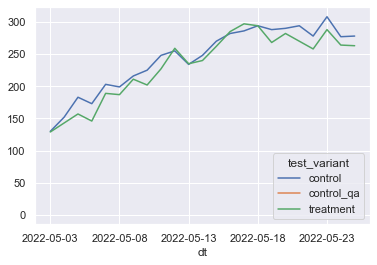

In [15]:
df.pivot_table(index='dt', columns='test_variant', values='visitor_id', aggfunc='nunique').plot()

## Remove outliers

In [16]:
# exclude qa
df = df.loc[~df['test_variant'].str.contains('qa')]

In [17]:
df[['dt', 'test_variant', 'visitor_id', 'order_gmv']].sort_values(by='order_gmv', ascending=False)

,dt,test_variant,visitor_id,order_gmv
10501,2022-05-19,control,0c2a2579-4427-4b19-b297-da0a994e9799,7907.00
8409,2022-05-06,treatment,d3d9656d-3d71-4b8b-92ef-9b36ebd1c413,6700.00
3609,2022-05-10,control,34665577-28f8-4c24-9dd9-dcbe0a8ad20b,6243.00
10437,2022-05-18,treatment,ffec8512-5630-44ac-9ea3-1c15d2ca9fb2,5040.99
602,2022-05-03,control,47d3ad3b-f44b-461b-9473-30c3284ce565,4790.01
...,...,...,...,...
10962,2022-05-19,control,87a4f99a-da7a-43c0-8a5a-71e7fb36a181,NaN
10964,2022-05-19,control,4416a750-55e2-4b7d-a607-e777b1dceefd,NaN
10965,2022-05-11,control,7244264c-89f9-4b26-85c4-ea21d82a4efd,NaN
10966,2022-05-15,control,e77427de-cb60-46cc-83ab-7f204eee7bc3,NaN


/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='order_gmv', ylabel='Density'>

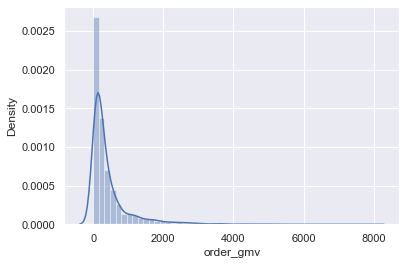

In [18]:
sns.distplot(df['order_gmv'])

<Figure size 1152x288 with 0 Axes>

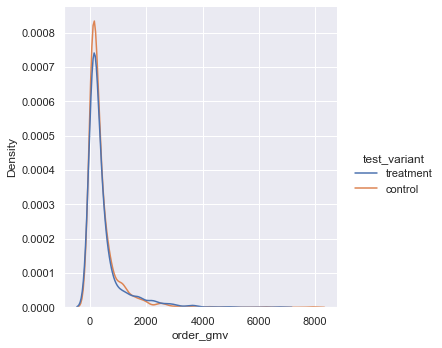

In [19]:
plt.figure(figsize=(16,4)) 
sns.displot(data=df, x='order_gmv', hue='test_variant', kind='kde')

In [20]:
# for some reason, treatment seems to have more large gmv orders
df.loc[df['order_gmv']>3000]['test_variant'].value_counts()

treatment    15
control      10
Name: test_variant, dtype: int64

In [21]:
# excluding 0 large order from control
df = df.loc[df['order_gmv']<10000]

In [22]:
metrics = df.columns[3:]
# df.groupby(['dt', 'test_variant']).apply(lambda x: x[metrics].sum()/x['visitor_id'].nunique())
dtd_metrics = df.groupby(['dt', 'test_variant']).apply(lambda x: x[metrics].sum()/x['visitor_id'].nunique()).reset_index()
dtd_metrics

,dt,test_variant,browse_products,view_product,cart_add,view_cart,checkout_launch,checkout_shipping,checkout_billing_and_payment,checkout_order_review,checkout_order_confirmation,signup,order_numbers,units_sold,order_gmv,order_gmv_w_coupon,net_commission,net_commission_w_coupon,new_orders,old_orders,cc_orders,apple_pay_orders,afterpay_orders,paypal_orders,cc_gmv,apple_pay_gmv,afterpay_gmv,paypal_gmv
0,2022-05-03,control,4.417910,4.776119,1.298507,1.671642,1.298507,1.208955,1.089552,1.373134,1.074627,0.910448,1.134328,1.507463,399.976269,398.632985,98.438128,97.094845,0.850746,0.283582,0.776119,0.000000,0.059701,0.298507,251.828955,0.000000,16.895821,131.251493
1,2022-05-03,treatment,5.060000,5.400000,1.360000,1.700000,1.740000,1.180000,1.940000,1.120000,1.200000,0.620000,1.040000,1.960000,551.657200,551.657200,115.991932,115.991932,0.720000,0.320000,0.780000,0.020000,0.040000,0.200000,496.392000,5.385400,7.879800,42.000000
2,2022-05-04,control,4.440678,3.847458,1.033898,1.423729,1.576271,1.610169,1.254237,1.474576,1.050847,0.830508,1.050847,1.322034,469.075763,465.855424,93.828844,90.608505,0.796610,0.254237,0.644068,0.016949,0.050847,0.338983,327.508136,1.915254,8.279492,131.372881
3,2022-05-04,treatment,3.864407,4.559322,1.169492,1.169492,1.542373,1.271186,2.000000,1.067797,1.152542,0.711864,1.135593,1.915254,436.789831,432.059831,84.330597,79.600597,0.745763,0.389831,0.745763,0.016949,0.050847,0.322034,314.870000,6.100847,9.649153,106.169831
4,2022-05-05,control,6.446429,5.214286,1.178571,1.553571,1.446429,1.642857,1.267857,1.303571,1.035714,0.553571,1.125000,1.517857,329.200536,326.164821,73.089775,70.054061,0.767857,0.357143,0.821429,0.017857,0.000000,0.285714,260.205536,0.875000,0.000000,68.120000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41,2022-05-23,treatment,4.323529,4.411765,1.308824,1.279412,1.661765,1.191176,2.176471,1.073529,1.147059,0.720588,1.073529,2.029412,374.383971,373.648676,87.870073,87.134779,0.779412,0.294118,0.808824,0.000000,0.014706,0.250000,279.427500,0.000000,1.264706,93.691765
42,2022-05-24,control,6.824561,6.807018,1.122807,2.210526,1.491228,1.491228,1.140351,1.508772,1.035088,0.614035,1.192982,1.578947,599.831053,596.209123,132.290035,128.668105,0.684211,0.508772,0.982456,0.000000,0.017544,0.192982,549.824211,0.000000,5.498772,44.508070
43,2022-05-24,treatment,5.326531,4.755102,1.122449,1.306122,1.795918,1.346939,2.102041,1.142857,1.265306,0.693878,1.081633,1.775510,433.743061,429.763469,92.304561,88.324969,0.653061,0.428571,0.795918,0.000000,0.040816,0.244898,339.518367,0.000000,5.747143,88.477551
44,2022-05-25,control,7.523810,7.000000,1.452381,1.809524,1.571429,1.380952,1.214286,1.571429,1.047619,0.571429,1.166667,2.190476,373.048571,371.381905,78.251379,76.584712,0.714286,0.452381,0.880952,0.000000,0.023810,0.261905,319.848810,0.000000,4.285476,48.914286


## Day to Day Metrics Plot

In [23]:
len(metrics)

26

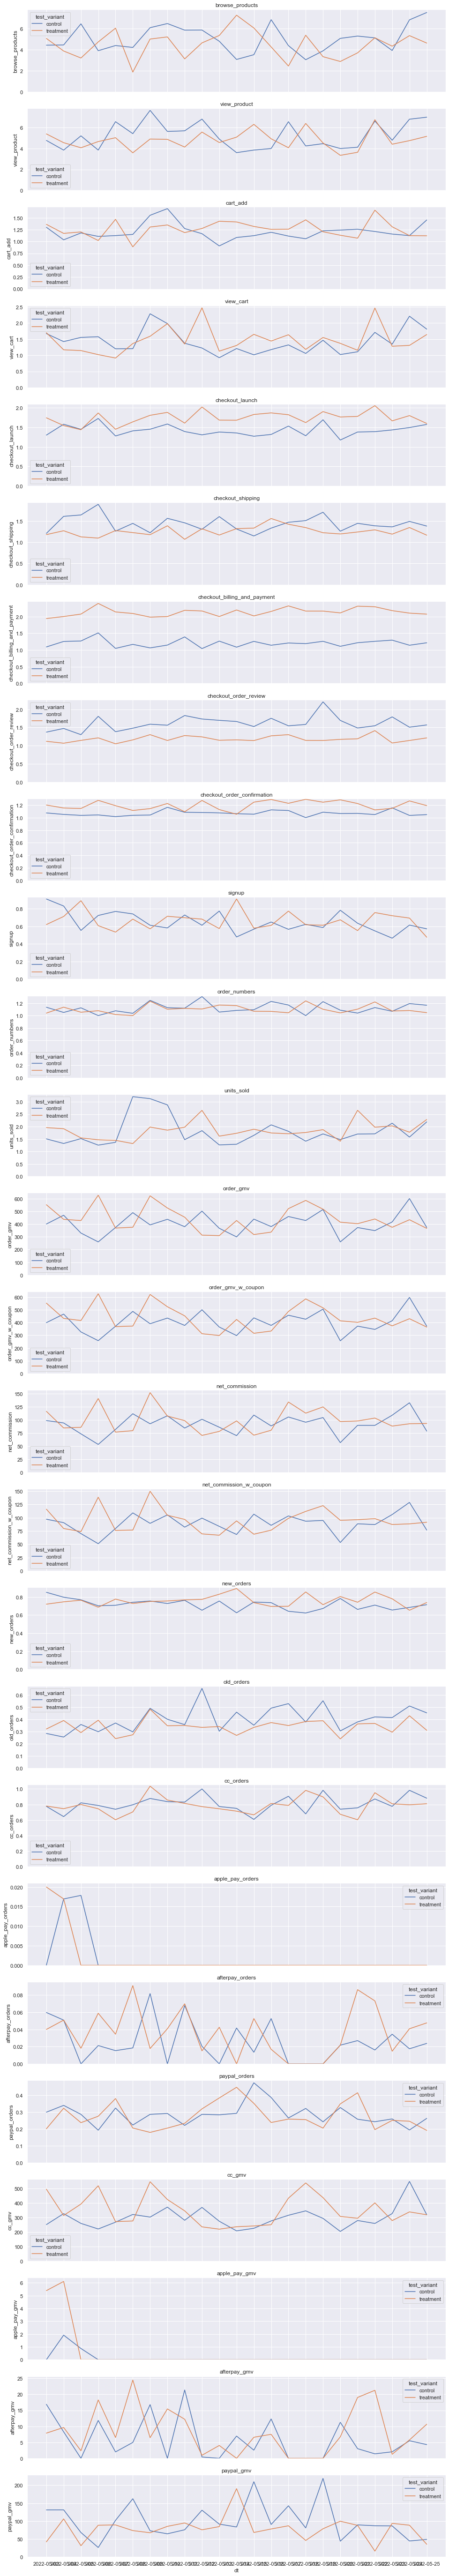

In [24]:
fig, axes = plt.subplots(26, 1, sharex=True, figsize=(16, 100))

for i, metric in enumerate(metrics):
    sns.lineplot(ax=axes[i], data=dtd_metrics, x='dt', y=metric, hue='test_variant')
    axes[i].set_title(metric)
    axes[i].set_ylim(ymin=0)

## Metrics Summary

In [25]:
q = """
select 
		test_variant,
        cast(crc32(to_utf8(visitor_id)) % 100 as int) as bucket,
        COUNT(DISTINCT visitor_id) as visitors,

		sum(browse_products) as browse_products,
		sum(view_product) as view_product,
		sum(cart_add) as cart_add,
		sum(view_cart) as view_cart,
		sum(checkout_launch) as checkout_launch,
		sum(checkout_shipping) as checkout_shipping,
		sum(checkout_billing_and_payment) as checkout_billing_and_payment,
		sum(checkout_order_review) as checkout_order_review,
		sum(checkout_order_confirmation) as checkout_order_confirmation,
		sum(signup) as signup,
		
		sum(order_numbers) as order_numbers,
		sum(units_sold) as units_sold,
		sum(order_gmv) as order_gmv,
		sum(order_gmv_w_coupon) as order_gmv_w_coupon,
		sum(net_commission) as net_commission,
		sum(net_commission_w_coupon) as net_commission_w_coupon,
		sum(new_orders) as new_orders,
		sum(old_orders) as old_orders,    
		sum(cc_orders) as cc_orders,
		sum(apple_pay_orders) as apple_pay_orders,
		sum(afterpay_orders) as afterpay_orders,
		sum(paypal_orders) as paypal_orders,
		sum(cc_gmv) as cc_gmv,
		sum(apple_pay_gmv) as apple_pay_gmv,
		sum(afterpay_gmv) as afterpay_gmv,
		sum(paypal_gmv) as paypal_gmv
from {tmp_final_table}
where order_gmv < 10000 or order_gmv is null
group by 1, 2
""".format(tmp_final_table=tmp_final_table)

df_all = pd.read_sql(q, conn)

df_all

,test_variant,bucket,visitors,browse_products,view_product,cart_add,view_cart,checkout_launch,checkout_shipping,checkout_billing_and_payment,checkout_order_review,checkout_order_confirmation,signup,order_numbers,units_sold,order_gmv,order_gmv_w_coupon,net_commission,net_commission_w_coupon,new_orders,old_orders,cc_orders,apple_pay_orders,afterpay_orders,paypal_orders,cc_gmv,apple_pay_gmv,afterpay_gmv,paypal_gmv
0,treatment,29,24,166,159,28,42,42,28,29,19,20,6,13.0,22.0,4706.86,4681.86,1028.8440,1003.8440,8.0,5.0,7.0,0.0,0.0,6.0,3487.66,0.0,0.00,1219.20
1,treatment,17,23,256,254,44,48,48,41,29,12,15,4,12.0,15.0,7313.79,7273.79,2002.4300,1962.4300,6.0,6.0,11.0,0.0,0.0,1.0,7103.88,0.0,0.00,209.91
2,treatment,66,26,186,275,35,61,46,26,41,16,13,9,8.0,8.0,1834.98,1834.98,373.3540,373.3540,5.0,3.0,5.0,0.0,0.0,3.0,1373.48,0.0,0.00,461.50
3,control,81,23,112,156,27,43,36,52,27,25,14,12,15.0,18.0,13404.55,13339.55,3246.8960,3181.8960,9.0,6.0,13.0,0.0,0.0,2.0,13304.56,0.0,0.00,99.99
4,control,43,21,159,192,30,39,37,35,15,25,13,16,11.0,17.0,7295.79,7255.79,2378.1122,2338.1122,7.0,4.0,7.0,0.0,0.0,4.0,1165.82,0.0,0.00,6129.97
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
196,control,37,23,227,151,32,41,34,45,24,19,13,11,12.0,15.0,3619.84,3619.84,986.7400,986.7400,8.0,4.0,8.0,0.0,1.0,3.0,2919.85,0.0,189.00,510.99
197,control,19,27,91,125,26,19,31,39,18,16,11,10,10.0,12.0,5006.48,4926.48,1112.6300,1032.6300,7.0,3.0,8.0,0.0,0.0,2.0,2453.98,0.0,0.00,2552.50
198,treatment,94,24,121,112,26,35,49,36,25,17,14,12,10.0,17.0,2134.60,1737.64,392.3100,-4.6500,9.0,1.0,8.0,0.0,0.0,2.0,1723.60,0.0,0.00,411.00
199,control,41,17,147,100,16,14,24,29,14,42,10,10,8.0,12.0,5522.09,5482.09,861.4750,821.4750,5.0,3.0,7.0,0.0,1.0,0.0,5004.28,0.0,517.81,0.00


In [26]:
# 16 rows with at least 1 na -> fillna with 0
df_all[metrics].isna().sum().sum()
df_all[metrics] = df_all[metrics].fillna(0)

In [27]:
avg_col_list = ['avg_' + m for m in metrics]
df_all[avg_col_list] = df_all[metrics].div(df_all['visitors'], axis=0)
df_all

,test_variant,bucket,visitors,browse_products,view_product,cart_add,view_cart,checkout_launch,checkout_shipping,checkout_billing_and_payment,checkout_order_review,checkout_order_confirmation,signup,order_numbers,units_sold,order_gmv,order_gmv_w_coupon,net_commission,net_commission_w_coupon,new_orders,old_orders,cc_orders,apple_pay_orders,afterpay_orders,paypal_orders,cc_gmv,apple_pay_gmv,afterpay_gmv,paypal_gmv,avg_browse_products,avg_view_product,avg_cart_add,avg_view_cart,avg_checkout_launch,avg_checkout_shipping,avg_checkout_billing_and_payment,avg_checkout_order_review,avg_checkout_order_confirmation,avg_signup,avg_order_numbers,avg_units_sold,avg_order_gmv,avg_order_gmv_w_coupon,avg_net_commission,avg_net_commission_w_coupon,avg_new_orders,avg_old_orders,avg_cc_orders,avg_apple_pay_orders,avg_afterpay_orders,avg_paypal_orders,avg_cc_gmv,avg_apple_pay_gmv,avg_afterpay_gmv,avg_paypal_gmv
0,treatment,29,24,166,159,28,42,42,28,29,19,20,6,13.0,22.0,4706.86,4681.86,1028.8440,1003.8440,8.0,5.0,7.0,0.0,0.0,6.0,3487.66,0.0,0.00,1219.20,6.916667,6.625000,1.166667,1.750000,1.750000,1.166667,1.208333,0.791667,0.833333,0.250000,0.541667,0.916667,196.119167,195.077500,42.868500,41.826833,0.333333,0.208333,0.291667,0.0,0.000000,0.250000,145.319167,0.0,0.000000,50.800000
1,treatment,17,23,256,254,44,48,48,41,29,12,15,4,12.0,15.0,7313.79,7273.79,2002.4300,1962.4300,6.0,6.0,11.0,0.0,0.0,1.0,7103.88,0.0,0.00,209.91,11.130435,11.043478,1.913043,2.086957,2.086957,1.782609,1.260870,0.521739,0.652174,0.173913,0.521739,0.652174,317.990870,316.251739,87.062174,85.323043,0.260870,0.260870,0.478261,0.0,0.000000,0.043478,308.864348,0.0,0.000000,9.126522
2,treatment,66,26,186,275,35,61,46,26,41,16,13,9,8.0,8.0,1834.98,1834.98,373.3540,373.3540,5.0,3.0,5.0,0.0,0.0,3.0,1373.48,0.0,0.00,461.50,7.153846,10.576923,1.346154,2.346154,1.769231,1.000000,1.576923,0.615385,0.500000,0.346154,0.307692,0.307692,70.576154,70.576154,14.359769,14.359769,0.192308,0.115385,0.192308,0.0,0.000000,0.115385,52.826154,0.0,0.000000,17.750000
3,control,81,23,112,156,27,43,36,52,27,25,14,12,15.0,18.0,13404.55,13339.55,3246.8960,3181.8960,9.0,6.0,13.0,0.0,0.0,2.0,13304.56,0.0,0.00,99.99,4.869565,6.782609,1.173913,1.869565,1.565217,2.260870,1.173913,1.086957,0.608696,0.521739,0.652174,0.782609,582.806522,579.980435,141.169391,138.343304,0.391304,0.260870,0.565217,0.0,0.000000,0.086957,578.459130,0.0,0.000000,4.347391
4,control,43,21,159,192,30,39,37,35,15,25,13,16,11.0,17.0,7295.79,7255.79,2378.1122,2338.1122,7.0,4.0,7.0,0.0,0.0,4.0,1165.82,0.0,0.00,6129.97,7.571429,9.142857,1.428571,1.857143,1.761905,1.666667,0.714286,1.190476,0.619048,0.761905,0.523810,0.809524,347.418571,345.513810,113.243438,111.338676,0.333333,0.190476,0.333333,0.0,0.000000,0.190476,55.515238,0.0,0.000000,291.903333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
196,control,37,23,227,151,32,41,34,45,24,19,13,11,12.0,15.0,3619.84,3619.84,986.7400,986.7400,8.0,4.0,8.0,0.0,1.0,3.0,2919.85,0.0,189.00,510.99,9.869565,6.565217,1.391304,1.782609,1.478261,1.956522,1.043478,0.826087,0.565217,0.478261,0.521739,0.652174,157.384348,157.384348,42.901739,42.901739,0.347826,0.173913,0.347826,0.0,0.043478,0.130435,126.950000,0.0,8.217391,22.216957
197,control,19,27,91,125,26,19,31,39,18,16,11,10,10.0,12.0,5006.48,4926.48,1112.6300,1032.6300,7.0,3.0,8.0,0.0,0.0,2.0,2453.98,0.0,0.00,2552.50,3.370370,4.629630,0.962963,0.703704,1.148148,1.444444,0.666667,0.592593,0.407407,0.370370,0.370370,0.444444,185.425185,182.462222,41.208519,38.245556,0.259259,0.111111,0.296296,0.0,0.000000,0.074074,90.888148,0.0,0.000000,94.537037
198,treatment,94,24,121,112,26,35,49,36,25,17,14,12,10.0,17.0,2134.60,1737.64,392.3100,-4.6500,9.0,1.0,8.0,0.0,0.0,2.0,1723.60,0.0,0.00,411.00,5.041667,4.666667,1.083333,1.458333,2.041667,1.500000,1.041667,0.708333,0.583333,0.500000,0.41

In [28]:
df_all.isna().sum().sum()

0

In [79]:
calculate(df_all, avg_col_list, control, treatment).reset_index().to_clipboard()

In [29]:

calculate(df_all, avg_col_list, control, treatment).reset_index()\
    .drop(columns=['index']).style.format({"Treatment Mean":"{:.4f}", "Control Mean":"{:.4f}", "Lift":"{:.5f}", "Lift_%":"{:.2%}", "P-value":"{:.4f}"}).apply(color_negative_red, axis = 1)

,Metric,Treatment Size,Treatment Total,Treatment Mean,Control Size,Control Total,Control Mean,Lift,Lift_%,P-value
0,avg_browse_products,2628,16322.000000,6.2217,2660,18043.000000,6.8480,-0.62634,-9.15%,0.1170
1,avg_view_product,2628,17241.000000,6.6253,2660,18468.000000,6.9956,-0.37030,-5.29%,0.3774
2,avg_cart_add,2628,3579.000000,1.3572,2660,3599.000000,1.3564,0.00079,0.06%,0.9856
3,avg_view_cart,2628,4251.000000,1.6174,2660,4382.000000,1.6510,-0.03366,-2.04%,0.7544
4,avg_checkout_launch,2628,4543.000000,1.7288,2660,3727.000000,1.4058,0.32305,22.98%,0.0000
5,avg_checkout_shipping,2628,3325.000000,1.2646,2660,4146.000000,1.5677,-0.30316,-19.34%,0.0000
6,avg_checkout_billing_and_payment,2628,3701.000000,1.4069,2660,2395.000000,0.8993,0.50756,56.44%,0.0000
7,avg_checkout_order_review,2628,1867.000000,0.7109,2660,2645.000000,0.9954,-0.28449,-28.58%,0.0000
8,avg_checkout_order_confirmation,2628,1640.000000,0.6228,2660,1465.000000,0.5503,0.07258,13.19%,0.0012
9,avg_signup,2628,1183.000000,0.4510,2660,1228.000000,0.4636,-0.01264,-2.73%,0.5374


# Prepare data to session level to slice by sign in status

In [37]:
pd.read_sql('drop table if exists {tmp_final_table}_by_signinstatus'.format(tmp_final_table=tmp_final_table), conn)

q = """
create table {tmp_final_table}_by_signinstatus AS
with xo as (

select dt, test_variant, visitor_id, signin_status, browser, session_id,

	-- xo metrics
		sum(coalesce(browse_products, 0)) browse_products,
		sum(coalesce(view_product, 0)) view_product,
 	    sum(coalesce(sm.cart_add,0)) as cart_add,
        sum(coalesce(sm.view_cart,0)) as view_cart,
	    sum(coalesce(sm.checkout_launch,0)) as checkout_launch,
    	sum(coalesce(sm.checkout_shipping,0)) as checkout_shipping,
    	sum(coalesce(sm.checkout_billing_and_payment,0)) as checkout_billing_and_payment,
    	sum(coalesce(sm.checkout_order_review,0)) as checkout_order_review,
	    sum(coalesce(sm.checkout_order_confirmation,0)) as checkout_order_confirmation,
	    sum(coalesce(sm.signup, 0)) as signup

from {tmp_xo_metrics} sm
group by 1, 2, 3, 4, 5, 6

)
, mp as (

select 

		order_date, test_variant, visitor_id,
		session_id,
	
	-- mp metrics
	    coalesce(count(distinct order_id),0) as order_numbers,
    	count(1) units_sold,
	    sum(coalesce(va.item_gmv,0)) as order_gmv,
	    sum(coalesce(va.item_gmv,0)+coalesce(placed_order_item_coupon_amount, 0)) as order_gmv_w_coupon,
	    sum(coalesce(net_commission, 0)) as net_commission,
	    sum(coalesce(net_commission, 0)+coalesce(placed_order_item_coupon_amount, 0)) as net_commission_w_coupon,
    	coalesce(count(distinct va.new_orders),0) as new_orders,
    	coalesce(count(distinct va.old_orders),0) as old_orders,    
	    coalesce(count(distinct cc_orders), 0) as cc_orders,
	    coalesce(count(distinct apple_pay_orders), 0) as apple_pay_orders,
	    coalesce(count(distinct afterpay_orders), 0) as afterpay_orders,
	    coalesce(count(distinct paypal_orders), 0) as paypal_orders,
	    sum(coalesce(cc_gmv, 0)) as cc_gmv,
	    sum(coalesce(apple_pay_gmv, 0)) as apple_pay_gmv,
	    sum(coalesce(afterpay_gmv, 0)) as afterpay_gmv,
	    sum(coalesce(paypal_gmv, 0)) as paypal_gmv
 from {tmp_mp_metrics} va
 group by 1, 2, 3, 4
)
, xo_sign as (

		select dt, visitor_id, session_id, cast(bool_or(cast(isusersignedin as boolean)) as int) + cast(bool_and(cast(isusersignedin as boolean)) as int) as signinstatus_xo
		from {tmp_xo_funnels}
		group by 1, 2, 3

)

select 
		coalesce(order_date, xo.dt) dt,
		coalesce(xo.test_variant, mp.test_variant) test_variant,
		coalesce(mp.visitor_id, xo.visitor_id) visitor_id,
		coalesce(mp.session_id, xo.session_id) session_id,
		signin_status,
		signinstatus_xo,
		browser,
		
		browse_products,
		view_product,
		cart_add,
		view_cart,
		checkout_launch,
		checkout_shipping,
		checkout_billing_and_payment,
		checkout_order_review,
		checkout_order_confirmation,
		signup,
		
		order_numbers,
		units_sold,
		order_gmv,
		order_gmv_w_coupon,
		net_commission,
		net_commission_w_coupon,
		new_orders,
		old_orders,    
		cc_orders,
		apple_pay_orders,
		afterpay_orders,
		paypal_orders,
		cc_gmv,
		apple_pay_gmv,
		afterpay_gmv,
		paypal_gmv
from xo
full join mp
on xo.session_id = mp.session_id
left join xo_sign
on coalesce(mp.session_id, xo.session_id) = xo_sign.session_id

""".format(tmp_xo_metrics=tmp_xo_metrics,
		    tmp_xo_funnels=tmp_xo_funnels,
            tmp_final_table=tmp_final_table,
            tmp_mp_metrics=tmp_mp_metrics
			)

# print(q)
pd.read_sql(q, conn)

,rows
0,19551


In [38]:
df_sign = pd.read_sql('select * from {tmp_final_table}_by_signinstatus'.format(tmp_final_table=tmp_final_table), conn)
df_sign

,dt,test_variant,visitor_id,session_id,signin_status,signinstatus_xo,browser,browse_products,view_product,cart_add,view_cart,checkout_launch,checkout_shipping,checkout_billing_and_payment,checkout_order_review,checkout_order_confirmation,signup,order_numbers,units_sold,order_gmv,order_gmv_w_coupon,net_commission,net_commission_w_coupon,new_orders,old_orders,cc_orders,apple_pay_orders,afterpay_orders,paypal_orders,cc_gmv,apple_pay_gmv,afterpay_gmv,paypal_gmv
0,2022-05-04,control,4f692339-acc8-41e2-a265-7e568257ed58,None,None,NaN,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,350.99,350.99,63.18,63.18,1.0,0.0,1.0,0.0,0.0,0.0,350.99,0.0,0.0,0.0
1,2022-05-08,control,b51fab31-856d-4afb-82c0-c9d2582a78a9,d0e44d204db0734361b839ab49e174ba,PARTIAL_SIGNED_IN,0.0,Mobile Safari,0.0,0.0,1.0,0.0,1.0,2.0,2.0,1.0,1.0,1.0,1.0,1.0,119.94,119.94,21.59,21.59,1.0,0.0,1.0,0.0,0.0,0.0,119.94,0.0,0.0,0.0
2,2022-05-11,treatment,bfb14b17-7974-4e87-8a89-212ac91b2b64,68d4a2c4d154604b054056e5564be762,PARTIAL_SIGNED_IN,NaN,Mobile Safari,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2022-05-09,control,a136f3c6-bcc7-40be-8a07-4dc2ba31d6ef,None,None,NaN,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,3.0,131.52,131.52,25.13,25.13,0.0,2.0,2.0,0.0,0.0,0.0,131.52,0.0,0.0,0.0
4,2022-05-04,treatment,e41e0726-6f54-46c5-bad8-54ebb8abc3d6,None,None,NaN,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,926.00,926.00,201.62,201.62,0.0,1.0,1.0,0.0,0.0,0.0,926.00,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19546,2022-05-07,control,43b3b0c5-b1e7-4bfc-b1b3-a64aafaa3377,d203d698f8101deeadeae5f09e0bf3b2,ALWAYS_SIGNED_IN,NaN,Mobile Safari,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
19547,2022-05-18,control,df877e30-eb6a-413f-96fc-dc9ad2b2195b,8f663e71a8cf52f15806963ddb2f5d6b,SIGNED_OUT,NaN,Chrome Mobile,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
19548,2022-05-08,control,609a838a-f81b-4590-a38a-34999e5d210c,aef5010b9adab74e9c3f717e2f93cf6a,ALWAYS_SIGNED_IN,NaN,Chrome Mobile,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
19549,2022-05-03,treatment,3635bff4-665e-4b9a-910e-db495488683c,bfd2c3099139db0e84392c1c8a39101a,SIGNED_OUT,0.0,Mobile Safari,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [33]:
# two fields not completely corelated
df_sign[['signin_status', 'signinstatus_xo']].drop_duplicates()

,signin_status,signinstatus_xo
0,None,NaN
11,SIGNED_OUT,NaN
12,ALWAYS_SIGNED_IN,NaN
13,ALWAYS_SIGNED_IN,2.0
16,PARTIAL_SIGNED_IN,1.0
...,...,...
107,PARTIAL_SIGNED_IN,NaN
251,SIGNED_IN_MULTIPLE,NaN
624,SIGNED_IN_MULTIPLE,2.0
686,SIGNED_IN_MULTIPLE,1.0


## Slice by session level signin status

In [34]:
# prepare data by slicing `signin_status`
q = """
select 
        signin_status, 
		--signinstatus_xo,
		test_variant,
        cast(crc32(to_utf8(visitor_id)) % 100 as int) as bucket,
        COUNT(DISTINCT visitor_id) as visitors,

		sum(browse_products) as browse_products,
		sum(view_product) as view_product,
		sum(cart_add) as cart_add,
		sum(view_cart) as view_cart,
		sum(checkout_launch) as checkout_launch,
		sum(checkout_shipping) as checkout_shipping,
		sum(checkout_billing_and_payment) as checkout_billing_and_payment,
		sum(checkout_order_review) as checkout_order_review,
		sum(checkout_order_confirmation) as checkout_order_confirmation,
		sum(signup) as signup,
		
		sum(order_numbers) as order_numbers,
		sum(units_sold) as units_sold,
		sum(order_gmv) as order_gmv,
		sum(order_gmv_w_coupon) as order_gmv_w_coupon,
		sum(net_commission) as net_commission,
		sum(net_commission_w_coupon) as net_commission_w_coupon,
		sum(new_orders) as new_orders,
		sum(old_orders) as old_orders,    
		sum(cc_orders) as cc_orders,
		sum(apple_pay_orders) as apple_pay_orders,
		sum(afterpay_orders) as afterpay_orders,
		sum(paypal_orders) as paypal_orders,
		sum(cc_gmv) as cc_gmv,
		sum(apple_pay_gmv) as apple_pay_gmv,
		sum(afterpay_gmv) as afterpay_gmv,
		sum(paypal_gmv) as paypal_gmv
from {tmp_final_table}_by_signinstatus
where order_gmv < 10000 or order_gmv is null
group by 1, 2, 3
""".format(tmp_final_table=tmp_final_table)

df_sign_ss = pd.read_sql(q, conn)

df_sign_ss

,signin_status,test_variant,bucket,visitors,browse_products,view_product,cart_add,view_cart,checkout_launch,checkout_shipping,checkout_billing_and_payment,checkout_order_review,checkout_order_confirmation,signup,order_numbers,units_sold,order_gmv,order_gmv_w_coupon,net_commission,net_commission_w_coupon,new_orders,old_orders,cc_orders,apple_pay_orders,afterpay_orders,paypal_orders,cc_gmv,apple_pay_gmv,afterpay_gmv,paypal_gmv
0,ALWAYS_SIGNED_IN,treatment,50,3,19.0,11.0,1.0,8.0,2.0,2.0,2.0,1.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,ALWAYS_SIGNED_IN,control,22,4,16.0,8.0,1.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,ALWAYS_SIGNED_IN,control,13,8,23.0,17.0,2.0,6.0,3.0,2.0,2.0,5.0,2.0,0.0,3.0,7.0,665.96,640.96,122.540,97.540,1.0,2.0,1.0,0.0,0.0,2.0,378.00,0.0,0.0,287.96
3,ALWAYS_SIGNED_IN,treatment,24,7,0.0,40.0,2.0,5.0,8.0,2.0,4.0,6.0,1.0,0.0,1.0,1.0,627.00,627.00,112.860,112.860,1.0,0.0,1.0,0.0,0.0,0.0,627.00,0.0,0.0,0.00
4,SIGNED_IN_MULTIPLE,treatment,98,2,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
745,ALWAYS_SIGNED_IN,control,19,4,1.0,6.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,169.00,169.00,41.620,41.620,0.0,1.0,1.0,0.0,0.0,0.0,169.00,0.0,0.0,0.00
746,PARTIAL_SIGNED_IN,control,89,13,18.0,25.0,14.0,9.0,17.0,17.0,14.0,15.0,13.0,1.0,14.0,19.0,3744.19,3744.19,937.670,937.670,9.0,5.0,7.0,0.0,0.0,7.0,1482.20,0.0,0.0,2261.99
747,PARTIAL_SIGNED_IN,control,14,14,40.0,37.0,12.0,9.0,15.0,18.0,15.0,12.0,9.0,4.0,8.0,24.0,2387.02,2387.02,506.725,506.725,3.0,5.0,7.0,0.0,0.0,1.0,2301.57,0.0,0.0,85.45
748,SIGNED_OUT,treatment,56,18,74.0,69.0,15.0,11.0,19.0,19.0,15.0,7.0,5.0,4.0,5.0,11.0,3627.87,3627.87,872.830,872.830,3.0,2.0,5.0,0.0,0.0,0.0,3627.87,0.0,0.0,0.00


In [63]:
df_sign_ss[metrics].isna().sum()
df_sign_ss[metrics] = df_sign_ss[metrics].fillna(0)

In [48]:
def metricSummary(df):
    df[metrics] = df[metrics].fillna(0)
    df[avg_col_list] = df[metrics].div(df['visitors'], axis=0)
    # metricSum = calculate(df, avg_col_list, control, treatment).reset_index()\
    # .drop(columns=['index']).style.format({"Treatment Mean":"{:.4f}", "Control Mean":"{:.4f}", "Lift":"{:.5f}", "Lift_%":"{:.2%}", "P-value":"{:.4f}"}).apply(color_negative_red, axis = 1)
    # return metricSum
    return calculate(df, avg_col_list, control, treatment)#.reset_index()#\
    #.drop(columns=['index']).style.format({"Treatment Mean":"{:.4f}", "Control Mean":"{:.4f}", "Lift":"{:.5f}", "Lift_%":"{:.2%}", "P-value":"{:.4f}"}).apply(color_negative_red, axis = 1)


In [65]:
# df_sign_ss.groupby('signin_status').apply(metricSummary).to_clipboard()
pd.set_option('display.max_rows', 10)
df_sign_ss.groupby('signin_status').apply(metricSummary).style.format({"Treatment Mean":"{:.4f}", "Control Mean":"{:.4f}", "Lift":"{:.5f}", "Lift_%":"{:.2%}", "P-value":"{:.4f}"}).apply(color_negative_red, axis = 1)

## Slice by signin status upon checkout

In [39]:
# prepare data by slicing `signin_status during xo`
q = """
select 
        --signin_status, 
		signinstatus_xo,
		test_variant,
        cast(crc32(to_utf8(visitor_id)) % 100 as int) as bucket,
        COUNT(DISTINCT visitor_id) as visitors,

		sum(browse_products) as browse_products,
		sum(view_product) as view_product,
		sum(cart_add) as cart_add,
		sum(view_cart) as view_cart,
		sum(checkout_launch) as checkout_launch,
		sum(checkout_shipping) as checkout_shipping,
		sum(checkout_billing_and_payment) as checkout_billing_and_payment,
		sum(checkout_order_review) as checkout_order_review,
		sum(checkout_order_confirmation) as checkout_order_confirmation,
		sum(signup) as signup,
		
		sum(order_numbers) as order_numbers,
		sum(units_sold) as units_sold,
		sum(order_gmv) as order_gmv,
		sum(order_gmv_w_coupon) as order_gmv_w_coupon,
		sum(net_commission) as net_commission,
		sum(net_commission_w_coupon) as net_commission_w_coupon,
		sum(new_orders) as new_orders,
		sum(old_orders) as old_orders,    
		sum(cc_orders) as cc_orders,
		sum(apple_pay_orders) as apple_pay_orders,
		sum(afterpay_orders) as afterpay_orders,
		sum(paypal_orders) as paypal_orders,
		sum(cc_gmv) as cc_gmv,
		sum(apple_pay_gmv) as apple_pay_gmv,
		sum(afterpay_gmv) as afterpay_gmv,
		sum(paypal_gmv) as paypal_gmv
from {tmp_final_table}_by_signinstatus
where order_gmv < 10000 or order_gmv is null
group by 1, 2, 3
""".format(tmp_final_table=tmp_final_table)

df_sign_xo = pd.read_sql(q, conn)

df_sign_xo

,signinstatus_xo,test_variant,bucket,visitors,browse_products,view_product,cart_add,view_cart,checkout_launch,checkout_shipping,checkout_billing_and_payment,checkout_order_review,checkout_order_confirmation,signup,order_numbers,units_sold,order_gmv,order_gmv_w_coupon,net_commission,net_commission_w_coupon,new_orders,old_orders,cc_orders,apple_pay_orders,afterpay_orders,paypal_orders,cc_gmv,apple_pay_gmv,afterpay_gmv,paypal_gmv
0,1.0,control,37,2,45,37,6,7,4,3,1,0,0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2.0,control,38,3,16,6,1,6,4,6,5,5,2,0,2.0,2.0,374.95,374.95,72.0400,72.0400,1.0,1.0,1.0,0.0,0.0,1.0,265.00,0.0,0.0,109.95
2,2.0,control,44,6,4,21,5,14,9,9,8,9,6,0,7.0,9.0,1595.19,1595.19,364.3600,364.3600,7.0,0.0,6.0,0.0,0.0,1.0,1515.21,0.0,0.0,79.98
3,2.0,treatment,9,7,116,23,3,14,17,3,10,6,5,3,6.0,8.0,409.97,409.97,97.9330,97.9330,2.0,4.0,4.0,0.0,1.0,1.0,115.98,0.0,250.0,43.99
4,2.0,treatment,85,2,0,8,1,2,2,2,5,2,1,0,1.0,3.0,780.00,780.00,374.3700,374.3700,1.0,0.0,1.0,0.0,0.0,0.0,780.00,0.0,0.0,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
755,NaN,treatment,92,18,26,44,5,15,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
756,NaN,treatment,86,13,55,44,3,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
757,0.0,treatment,86,18,69,80,22,24,26,24,25,11,10,15,10.0,87.0,8801.03,8761.03,2531.4800,2491.4800,9.0,1.0,8.0,0.0,1.0,1.0,8263.07,0.0,418.0,119.96
758,1.0,treatment,39,3,4,8,2,8,10,3,6,3,1,0,1.0,2.0,60.58,60.58,10.9000,10.9000,0.0,1.0,0.0,0.0,0.0,1.0,0.00,0.0,0.0,60.58


In [42]:
df_sign_xo['signinstatus_xo'].value_counts()

Did not checkout    201
Never signin        200
Always signin       197
Signin during XO    162
Name: signinstatus_xo, dtype: int64

In [41]:
df_sign_xo['signinstatus_xo'].replace({0.0:'Never signin', 1.0:'Signin during XO', 2.0:'Always signin'}, inplace=True)
df_sign_xo['signinstatus_xo'].fillna('Did not checkout', inplace=True)

In [43]:
df_sign_xo[metrics].isna().sum()

browse_products      0
view_product         0
cart_add             0
view_cart            0
checkout_launch      0
                  ... 
paypal_orders      235
cc_gmv             235
apple_pay_gmv      235
afterpay_gmv       235
paypal_gmv         235
Length: 26, dtype: int64

In [44]:
df_sign_xo[metrics] = df_sign_xo[metrics].fillna(0)

In [45]:
df_sign_xo[metrics].isna().sum().sum()

0

In [46]:
df_sign_xo

,signinstatus_xo,test_variant,bucket,visitors,browse_products,view_product,cart_add,view_cart,checkout_launch,checkout_shipping,checkout_billing_and_payment,checkout_order_review,checkout_order_confirmation,signup,order_numbers,units_sold,order_gmv,order_gmv_w_coupon,net_commission,net_commission_w_coupon,new_orders,old_orders,cc_orders,apple_pay_orders,afterpay_orders,paypal_orders,cc_gmv,apple_pay_gmv,afterpay_gmv,paypal_gmv
0,Signin during XO,control,37,2,45,37,6,7,4,3,1,0,0,1,0.0,0.0,0.00,0.00,0.0000,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.00
1,Always signin,control,38,3,16,6,1,6,4,6,5,5,2,0,2.0,2.0,374.95,374.95,72.0400,72.0400,1.0,1.0,1.0,0.0,0.0,1.0,265.00,0.0,0.0,109.95
2,Always signin,control,44,6,4,21,5,14,9,9,8,9,6,0,7.0,9.0,1595.19,1595.19,364.3600,364.3600,7.0,0.0,6.0,0.0,0.0,1.0,1515.21,0.0,0.0,79.98
3,Always signin,treatment,9,7,116,23,3,14,17,3,10,6,5,3,6.0,8.0,409.97,409.97,97.9330,97.9330,2.0,4.0,4.0,0.0,1.0,1.0,115.98,0.0,250.0,43.99
4,Always signin,treatment,85,2,0,8,1,2,2,2,5,2,1,0,1.0,3.0,780.00,780.00,374.3700,374.3700,1.0,0.0,1.0,0.0,0.0,0.0,780.00,0.0,0.0,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
755,Did not checkout,treatment,92,18,26,44,5,15,0,0,0,0,0,0,0.0,0.0,0.00,0.00,0.0000,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.00
756,Did not checkout,treatment,86,13,55,44,3,0,0,0,0,0,0,0,0.0,0.0,0.00,0.00,0.0000,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.00
757,Never signin,treatment,86,18,69,80,22,24,26,24,25,11,10,15,10.0,87.0,8801.03,8761.03,2531.4800,2491.4800,9.0,1.0,8.0,0.0,1.0,1.0,8263.07,0.0,418.0,119.96
758,Signin during XO,treatment,39,3,4,8,2,8,10,3,6,3,1,0,1.0,2.0,60.58,60.58,10.9000,10.9000,0.0,1.0,0.0,0.0,0.0,1.0,0.00,0.0,0.0,60.58


In [49]:
df_sign_xo.groupby('signinstatus_xo').apply(metricSummary).to_clipboard()
pd.set_option('display.max_rows', None)
df_sign_xo.groupby('signinstatus_xo').apply(metricSummary).style.format({"Treatment Mean":"{:.4f}", "Control Mean":"{:.4f}", "Lift":"{:.5f}", "Lift_%":"{:.2%}", "P-value":"{:.4f}"}).apply(color_negative_red, axis = 1)

## Slice by Browser

In [ ]:
# prepare data by slicing `signin_status during xo`
q = """
select 
        browser,
		test_variant,
        cast(crc32(to_utf8(visitor_id)) % 100 as int) as bucket,
        COUNT(DISTINCT visitor_id) as visitors,

		sum(browse_products) as browse_products,
		sum(view_product) as view_product,
		sum(cart_add) as cart_add,
		sum(view_cart) as view_cart,
		sum(checkout_launch) as checkout_launch,
		sum(checkout_shipping) as checkout_shipping,
		sum(checkout_billing_and_payment) as checkout_billing_and_payment,
		sum(checkout_order_review) as checkout_order_review,
		sum(checkout_order_confirmation) as checkout_order_confirmation,
		sum(signup) as signup,
		
		sum(order_numbers) as order_numbers,
		sum(units_sold) as units_sold,
		sum(order_gmv) as order_gmv,
		sum(order_gmv_w_coupon) as order_gmv_w_coupon,
		sum(net_commission) as net_commission,
		sum(net_commission_w_coupon) as net_commission_w_coupon,
		sum(new_orders) as new_orders,
		sum(old_orders) as old_orders,    
		sum(cc_orders) as cc_orders,
		sum(apple_pay_orders) as apple_pay_orders,
		sum(afterpay_orders) as afterpay_orders,
		sum(paypal_orders) as paypal_orders,
		sum(cc_gmv) as cc_gmv,
		sum(apple_pay_gmv) as apple_pay_gmv,
		sum(afterpay_gmv) as afterpay_gmv,
		sum(paypal_gmv) as paypal_gmv
from {tmp_final_table}_by_signinstatus
where order_gmv < 10000 or order_gmv is null
group by 1, 2, 3
""".format(tmp_final_table=tmp_final_table)

df_by_browser = pd.read_sql(q, conn)

df_by_browser

In [52]:
df_by_browser

,browser,test_variant,bucket,visitors,browse_products,view_product,cart_add,view_cart,checkout_launch,checkout_shipping,checkout_billing_and_payment,checkout_order_review,checkout_order_confirmation,signup,order_numbers,units_sold,order_gmv,order_gmv_w_coupon,net_commission,net_commission_w_coupon,new_orders,old_orders,cc_orders,apple_pay_orders,afterpay_orders,paypal_orders,cc_gmv,apple_pay_gmv,afterpay_gmv,paypal_gmv
0,Android browser,control,59,1,83.0,60.0,6.0,19.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,405.55,405.55,73.0000,73.0000,1.0,0.0,1.0,0.0,0.0,0.0,405.55,0.0,0.0,0.00
1,Chrome Mobile,treatment,36,6,6.0,7.0,5.0,8.0,12.0,9.0,4.0,3.0,2.0,1.0,2.0,2.0,118.99,118.99,22.0400,22.0400,1.0,1.0,2.0,0.0,0.0,0.0,118.99,0.0,0.0,0.00
2,Chrome Mobile,treatment,67,10,66.0,181.0,25.0,31.0,16.0,12.0,11.0,9.0,7.0,1.0,5.0,6.0,1941.99,1916.99,800.2886,775.2886,1.0,4.0,4.0,0.0,0.0,1.0,555.99,0.0,0.0,1386.00
3,Chrome Mobile,control,99,6,22.0,29.0,5.0,5.0,6.0,9.0,6.0,5.0,4.0,5.0,4.0,5.0,855.46,855.46,211.7400,211.7400,3.0,1.0,4.0,0.0,0.0,0.0,855.46,0.0,0.0,0.00
4,Mobile Safari,treatment,49,15,64.0,85.0,18.0,25.0,33.0,18.0,26.0,15.0,10.0,6.0,8.0,9.0,1803.12,1803.12,350.1900,350.1900,6.0,2.0,6.0,0.0,0.0,2.0,828.89,0.0,0.0,974.23
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
531,Mobile Safari,control,81,20,108.0,139.0,24.0,38.0,29.0,37.0,22.0,20.0,11.0,8.0,12.0,15.0,7050.56,7010.56,2098.6260,2058.6260,7.0,5.0,11.0,0.0,0.0,1.0,6999.56,0.0,0.0,51.00
532,Mobile Safari,treatment,51,20,162.0,176.0,41.0,51.0,35.0,25.0,35.0,16.0,13.0,7.0,12.0,13.0,9184.81,9159.81,1791.0800,1766.0800,8.0,4.0,9.0,0.0,0.0,3.0,8711.98,0.0,0.0,472.83
533,Mobile Safari,treatment,83,24,257.0,191.0,33.0,31.0,51.0,32.0,36.0,22.0,14.0,12.0,14.0,18.0,4661.89,4641.89,1078.9500,1058.9500,9.0,5.0,5.0,0.0,0.0,9.0,1615.08,0.0,0.0,3046.81
534,Other,treatment,92,2,2.0,6.0,2.0,3.0,4.0,3.0,7.0,3.0,2.0,0.0,2.0,3.0,468.00,468.00,127.1100,127.1100,2.0,0.0,1.0,0.0,0.0,1.0,132.00,0.0,0.0,336.00


In [54]:
df_by_browser[metrics] = df_by_browser[metrics].fillna(0)

# Checkout Conversions

In [58]:
q = """
    select  test_variant,
            session_id,
            visitor_id, 
            sum(if(signup>0, 1, 0)) signup,
            sum(if(checkout_launch>0, 1, 0)) checkout_launch,
            sum(if(checkout_shipping>0, 1, 0)) checkout_shipping,
            sum(if(checkout_billing_and_payment>0, 1, 0)) checkout_billing_and_payment,
            sum(if(checkout_order_review>0, 1, 0)) checkout_order_review,
            sum(if(checkout_order_confirmation>0, 1, 0)) checkout_order_confirmation 
    from wandajuan.xo_metrics_mp_checkout_mweb_v3
    group by 1, 2, 3
    """

df_xo = pd.read_sql(q, conn)

In [61]:
df_xo.head()

,test_variant,session_id,visitor_id,signup,checkout_launch,checkout_shipping,checkout_billing_and_payment,checkout_order_review,checkout_order_confirmation
0,control,a994e4abd6437fb7794c0532ad43125c,c86935aa-a010-41e4-9f11-5907020ccf35,0,0,0,0,0,0
1,treatment,843a6f640bc8271c0429af2851133a1c,eb9ededa-5612-4c9f-91ca-c9cd79e117b8,0,0,0,0,0,1
2,control,6293065c64d795903b1c12af3459209b,31ebfd5e-c65c-4555-81ff-0078675ec605,0,0,0,0,0,0
3,control,450e8d135ec9ca810faf552e89148e96,5bc4f67e-65ff-4376-95ac-040223363324,0,0,0,0,0,0
4,control,dd037a2fc6c81adaea2f29e83eec2c30,c7eb93a6-460d-4c76-a674-87f57e1fb62b,0,0,0,0,0,0


In [76]:
from scipy import stats
from statsmodels.stats.proportion import proportions_ztest

# outputs proportion test results on binary values
def calculate_prop(input_df, col_list, control, treatment):    
    columns = ['Metric', 'Treatment Size', 'Treatment Total',
               'Control Size', 'Control Total', 'P-value']

    ctl_size = input_df[(input_df['test_variant'] == control)] ['visitors'].sum()
    trt_size = input_df[(input_df['test_variant'] == treatment)] ['visitors'].sum()
    #total_sample_size = ctl_size + trt_size

    df_egg_overall = pd.DataFrame(columns=columns)
    for metric in col_list:
        ctl = input_df[(input_df['test_variant'] == control)][metric].sum()
        trt = input_df[(input_df['test_variant'] == treatment)][metric].sum()
        row = [metric, trt_size, trt, ctl_size, ctl, proportions_ztest(input_df[metric], input_df['visitors'])[1]]
        df_egg_overall = df_egg_overall.append(
            pd.Series(row, index=columns),
            ignore_index=True)
    
    df_egg_overall['Treatment Mean'] =\
        df_egg_overall['Treatment Total'] / df_egg_overall['Treatment Size']
    df_egg_overall['Control Mean'] =\
        df_egg_overall['Control Total'] / df_egg_overall['Control Size']
    
    df_egg_overall['Lift'] =\
        df_egg_overall['Treatment Mean'] - df_egg_overall['Control Mean']
    df_egg_overall['Lift_%'] =\
        (df_egg_overall['Treatment Mean'] - df_egg_overall['Control Mean'])/ (df_egg_overall['Control Mean']+1e-12)
    return df_egg_overall[['Metric','Treatment Size', 'Treatment Total', 'Treatment Mean', 'Control Size', 'Control Total', 'Control Mean',
                           'Lift', 'Lift_%', 'P-value']]

In [62]:
df_xo.columns[3:]

Index(['signup', 'checkout_launch', 'checkout_shipping',
       'checkout_billing_and_payment', 'checkout_order_review',
       'checkout_order_confirmation'],
      dtype='object')

In [66]:
df_xo = df_xo.loc[~df_xo['test_variant'].str.contains('qa')]

In [68]:
df_xo['visitors'] = 1

<ipython-input-68-d7baad0446a6>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_xo['visitors'] = 1


In [72]:
df_conversions = df_xo.groupby('test_variant')[df_xo.columns[3:]].sum().reset_index()

In [73]:
df_conversions

,test_variant,signup,checkout_launch,checkout_shipping,checkout_billing_and_payment,checkout_order_review,checkout_order_confirmation,visitors
0,control,956,3025,2928,1904,1689,1393,10035
1,treatment,921,3102,2697,1863,1559,1397,9499


In [74]:
df_conversions.columns[1:-1]

Index(['signup', 'checkout_launch', 'checkout_shipping',
       'checkout_billing_and_payment', 'checkout_order_review',
       'checkout_order_confirmation'],
      dtype='object')

In [77]:
calculate_prop(df_conversions, df_conversions.columns[1:-1], 'control', 'treatment').reset_index()\
    .drop(columns=['index']).style.format({"Treatment Mean":"{:.4f}", "Control Mean":"{:.4f}", "Lift":"{:.5f}", "Lift_%":"{:.2%}", "P-value":"{:.4f}"}).apply(color_negative_red, axis = 1)

,Metric,Treatment Size,Treatment Total,Treatment Mean,Control Size,Control Total,Control Mean,Lift,Lift_%,P-value
0,signup,9499,921,0.0970,10035,956,0.0953,0.00169,1.78%,0.6886
1,checkout_launch,9499,3102,0.3266,10035,3025,0.3014,0.02512,8.33%,0.0002
2,checkout_shipping,9499,2697,0.2839,10035,2928,0.2918,-0.00785,-2.69%,0.2256
3,checkout_billing_and_payment,9499,1863,0.1961,10035,1904,0.1897,0.00639,3.37%,0.2579
4,checkout_order_review,9499,1559,0.1641,10035,1689,0.1683,-0.00419,-2.49%,0.4320
5,checkout_order_confirmation,9499,1397,0.1471,10035,1393,0.1388,0.00825,5.95%,0.0994


In [78]:
calculate_prop(df_conversions, df_conversions.columns[1:-1], 'control', 'treatment').reset_index().to_clipboard()